___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.carrerasenlinea.mx/logos/original/logo-instituto-tecnologico-y-de-estudios-superiores-de-occidente.png" width="150px" height="100px" />


# MICROESTRUCTURAS Y SISTEMAS DE "TRADING"
# LABORATORIO 1

## Nombre: Jocelyn Medel Ruiz, Hannia Lomeli, Carlos Ochoa

## Fecha: 15 de Septiembre 2019

## Introducción

Dentro de este primer laboratorio se busca analizar detalladamente un ETF, en nuestro caso, el OEF. Para lograr la realización de este proyecto, nos apoyamos en la programación usando múltiples librerías y creando diferentes funciones de acuerdo a lo que necesitabamos para llegar a las conclusiones deseadas. 

Se busca que el siguiente trabajo, sea entenbile a cualquier persona con conocimientos financieros y nulos de programación.

Como el trabajo se basa en un ETF, a continuación describiremos un poco más este instrumento financiero

### ¿Qué es un ETF?

Un Exchange Traded Fund, ETF, por sus siglas en inglés es un conjunto diversificado de activos, como un fondo de inversión, que cotiza en bolsa (como si fuera una acción). Los ETFs le permiten invertir su dinero fácilmente, con bajo costo y de manera eficiente a nivel impositivo.

### ¿Qué beneficios tienen los ETF?

**1.** El costo, la conveniencia y la variedad son los motivos por los cuales los inversionistas deben considerar el uso de ETFs en sus carteras.

**2.** Flexibilidad: los ETFs proporcionan exposiciones que se adaptan tanto a su cartera básica como a su inversión táctica.

**3.** Efectividad en costos: los ETFs suelen tener comisiones de gestión más bajas que los fondos activos y sus costos son más fáciles de calcular.

**4.** Diversificación: los ETFs ofrecen exposición instantánea a valores diversos en cada fondo (vehículo u operación)

**5.** Transparencia: los ETFs muestran cada valor incluido actualmente en el mismo a fin de que usted sepa exactamente lo que tiene.

**6.** Liquidez: los ETFs cotizan en bolsa y pueden comercializarse en cualquier momento durantela sesión bursátil.

**7.** Acceso: los ETFs permiten un acceso instantáneo a los mercados internacionales.

### ¿Qué ETF se analizará?

__OEF:__ El ETF iShares S&P 100 busca replicar los resultados de inversión de un índice compuesto por 100 valores de renta variable de alta capitalización de EE.UU.

* Exposición a las empresas más grandes de EE. UU.

* Acceso a 100 valores locales con tope máximo de capitalización en un solo fondo

* Usado para buscar crecimiento a largo plazo de la cartera

## Primera Parte: Análisis de Datos
************

Importamos todas las librerías necesarias

In [71]:
import quandl 
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

Para la resolución de este problema, creamos 5 funciones diferentes, cada una con un propósito que describiré a continuación:

* __Download_excel_csv:__ Esta función guarda el Excel con los datos de Ishare 
* __Download_quandl:__ Función para bajar los datos de Quandl
* __Clean_data:__ Esta función borra lo que no tengo igual de la lista de Ishares y Quandl
* __Acciones:__ Esta función calcula el tamaño de las acciones que necesitamos
* __Re_balance:__ Esta función hace un rebalanceo del ETF

In [72]:
def download_excel_csv(num_files, dir_, f_name):
    #num_files: Número de archivos que tenemos
    #dir_: Directorio
    #f_name: Prefijo del nombre del archivo
    d = {} #Diccionario vacío
    for i in range(num_files): 
        nom_arch = f_name+str(i+1)+".csv"    
        dir_f = dir_+nom_arch
        data = pd.read_csv(dir_f, skiprows=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        d["Data_{0}".format(i+1)] = data   
    return d
    # Nos regresa un diccionario DF con los datos

In [73]:
def download_quandl(dates, num_files):
    # dates = lista de las fechas a bajar
    # num_files = Número de archivos que tenemos
    d2 = {}  #Diccionario vacío
    for i in range(num_files):  
        nom = "Data_"+str(i+1)
        ticker_r = list(d[nom]["Ticker"])  #Lista de Tickers
        date = {'gte': dates[i], 'lte': dates[i] }
        column = {'columns': ['ticker', 'date', 'Adj_close']}
        data = quandl.get_table('WIKI/PRICES', qopts=column, ticker=ticker_r, date=date, paginate=True)
        d2["Data_{0}".format(i+1)] = data.set_index('ticker')
        d[nom] = d[nom].set_index('Ticker')  # Ticker is set as index
    return d2
    # Nos regresa un diccionario de datos con los datos de Quandl

In [74]:
def clean_data(num_files, d, d2):
    # num_files = Número de archivos que tenemos
    # d: Diccionario creado de Excel
    # d2: Diccionario creado de Quandl
    
    d3 = {}  #Diccionario vacío
    for i in range(num_files):
        nom = "Data_"+str(i+1)
        a = set(list(d[nom].index)) #Set es conjunto, ¡¡con la lista no podemos hacer las mismas operaciones!!
        b = set(list(d2[nom].index))
        c = list(a-b)  # Compara las dos listas, para quitarlo después
        data_1 = d[nom] # Tabla 1 de ishares
        data_2 = d2[nom] # Tabla 1 de Quandl
        data_1 = data_1.drop(c, axis=0)  #Quita los activos que Quandl no tiene
        data_1 = data_1.drop(["Name", "Asset Class", "Market Value", "Shares", "Notional Value",
                              "Sector", "SEDOL", "ISIN", "Exchange"], 1)  #Quito las 1=columnas que no necesito
        data = data_1.join(data_2) #Junto los dos  
        data = data.drop("date", axis = 1) #Quito date porque ya esta en los dos cuando se junto
        data.columns = (["Weight","Start", "End"]) #Columnas vacías, start y end= precio de acciones en el periodo
        data['Start'] = data['Start'].str.replace(',', '') #Las comas no las lee, y las quito
        data['Weight'] = data['Weight']/100 #Quitar porcentaje
        data['Start'] = pd.to_numeric(data['Start']) #Lo paso a número para hacer operaciones
        d3["Data_{0}".format(i+1)] = data 
    return d3

In [75]:
def acciones(d, initial_capital):
    # d = Data Frame
    # initial_capital: Capital inicial con el que contamos
    shares_ = pd.DataFrame(np.floor((d['Weight']*initial_capital)/d['Start']), columns=['Shares'])
    d = d.join(shares_) #Floor redondea para abajo, porque no puedes comprar 1.1 
    #Le agregas al dataframe las acciones calculadas
    return d
    # Regesa un Data Frame con la cantidad de acciones por activo

In [111]:
def re_balance(d_1, d_2, in_capital, l_cap, l_nav, remainder):
    # d_1: Data Frame MES 1
    # d_2: Data Frame MES 2
    # in_capital: Capital Inicial
    # l_cap: Lista para poner aqui el capital ya rebalanceado
    # l_nav: Lista para poner el NAV ya rebalanceado
    # remainder: Lo que queda en la cuenta, primero vendes para recuperar dinero y luego compras 
    
    # Diferencias entre Tickers
    # Tickers mes 1 - Tickers mes 2
    a = list(set(list(d_1.index))-set(list(d_2.index))) #Los que fueron vendidos
    # Intersección entre los dos
    b = list(set(list(d_2.index))-set(list(set(list(d_2.index))-set(list(d_1.index))))) #Los que se quedan
    # Tickers mes 2 - Tickers 1
    c = list(set(list(d_2.index))-set(list(d_1.index)))  #Los que fueron comprados
    
    # Vender Acciones
    df_sell = d_1.drop(b, 0)
    # value= precio x número de acciones y la suma es el valor monetario #
    value = sum(df_sell.iloc[:, 2]*df_sell.iloc[:, 3])
    # Como es lo que vendes, esto lo sumas a lo tuyo
    remainder += (value)
    
    # Comprar Acciones
    df_buy = d_2.drop(b, 0)
    # value= precio x número de acciones y la suma es el valor monetario #
    value = sum(df_buy.iloc[:, 2]*df_buy.iloc[:, 3])
    # Como es lo que compras, se lo restas a lo tuyo
    remainder -= (value)
    
    # Rebalancear posiciones
    # y1 y y2 intersecciones entre ambos
    y1 = d_1.drop(a, 0)  # Intersección
    y2 = d_2.drop(c, 0)  # " "
    y1 = y1.sort_index() # Te lo acomoda por orden
    y2 = y2.sort_index() # " "
    shares_c_v = np.floor(((y2['Weight']-y1['Weight'])*in_capital)/y2['End'])
    
    # Cuando en valor en Shares_c_v es +, COMPRAR
    # Cuando en valor en Shares_c_v es -, VENDER
    
    value = (shares_c_v*y2['End']).sum() #.sum hace el de todos y te deja un número
    remainder += (value) 
    
    # Resultados del rebalanceo
    # Sacamos las métricas
    nav = sum(d_1['End']*d_1['Shares'])/sum(d_1['Shares'])
    cap_ = sum(d_2['End']*d_2['Shares']) + remainder
    l_nav.append(nav)
    l_cap.append(cap_)
    return l_cap, l_nav, remainder
    # Nos regresa la lista de capital, lista de NAV y el valor del sobrante 

El periodo de fechas a analizar, abarca del 28/02/17 al 28/02/18:

In [112]:
dates_to = list(['2017-02-28','2017-03-28', '2017-04-28', '2017-05-31', '2017-06-30', '2017-07-31',
                 '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30', '2017-12-29',
                 '2018-01-31', '2018-02-28'])

Api de Quandl para poder bajar los datos:

In [113]:
quandl.ApiConfig.api_key = "Kdc4WJ4qKJehx9jNpL8t" 

A continuación mandamos a llamar las funciones de __download_excel_csv__, __download_quandl__, __clean_data__ y __acciones__. Para fines del ejercicio, supusimos tener un capital inicial de 10 millones y no tenemos costos de transacción. 

In [152]:
num_ar = 13  # Numero de archivos a importar
d = download_excel_csv(num_ar,"/Users/Lilly Lomeli Salado/Desktop/7mo semestre/Trading/Lab1/Lab1/HISTORICOS/","OEF_")
d2 = download_quandl(dates_to, num_ar)
d3 = clean_data(num_ar, d, d2)    
Initial_Capital = 10000000  #Diez millones

for i in range(num_ar):
    nom = "Data_"+str(i+1)
    #mes 1 de la unión, ...  #de cada mes me calcula las acciones
    d3["Data_{0}".format(i+1)] = acciones(d3[nom], Initial_Capital)  # De OEF_1 a OEF_13
    
l_Cap = list()
l_NAV = list()
ind = list(d3.keys()) #del diccionario d3 me hace una lista de las llaves: FORMA DE ACCESAR 

#S = In_Cap -             SUM(precio final   *  cantidad de acciones)
S = Initial_Capital - sum(d3['Data_1']['End']*d3['Data_1']['Shares']) 

# Aqui mandamos a llamar la funcion de __re_balance__ con los parámetros 
# correspondientes descritos anteriormente:

for p in range(len(ind)-1):
    # mes 1 vs mes 2 
    l_Cap, l_NAV, S = re_balance(d3[ind[p]], d3[ind[p+1]], Initial_Capital, l_Cap, l_NAV, S)

Mostraremos graficamente el Valor del Portafolio con el Rebalanceo Mensual y el NAV, en las fechas analizadas:

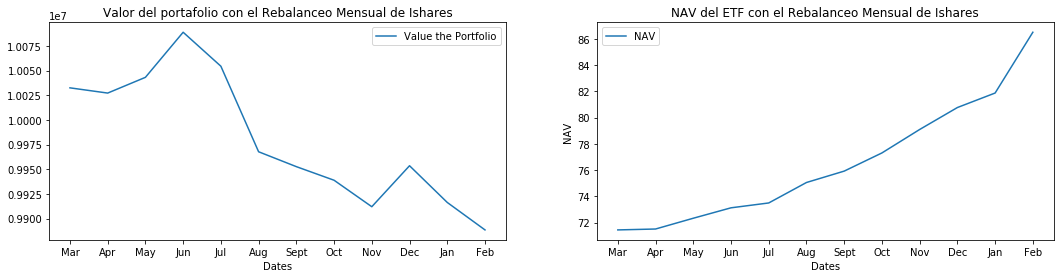

In [142]:
plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(l_Cap, label='Value the Portfolio')
plt.title('Valor del portafolio con el Rebalanceo Mensual de Ishares')
plt.xticks(np.arange(0, 12, 1), ('Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb'))
plt.xlabel('Dates')
plt.ylabel('')
plt.legend()
plt.subplot(122)
plt.plot(l_NAV, label='NAV')
plt.title('NAV del ETF con el Rebalanceo Mensual de Ishares')
plt.xticks(np.arange(0, 12, 1), ('Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb'))
plt.xlabel('Dates')
plt.ylabel('NAV')
plt.legend()

In [157]:
# Sacamos rendimiento
Rend = ((pd.DataFrame(l_Cap, columns=['Rendimiento'])-Initial_Capital)/Initial_Capital)*100
Rend

,Rendimiento
0,0.325416
1,0.272358
2,0.431928
3,0.889219
4,0.544610
5,-0.322812
6,-0.473727
7,-0.611604
8,-0.880106
9,-0.464585


## Segunda Parte: Métricas
***

* __¿Qué es el Rendimiento?__

El rendimiento financiero, por lo tanto, es la ganancia que permite obtener una cierta operación. Se trata de un cálculo que se realiza tomando la inversión realizada y la utilidad generada luego de un cierto periodo.

&nbsp;
* __¿Qué es la Desviación Estandar?__

Ésta es una medida del riesgo de una acción individual y de portafolios de activos.

&nbsp;
* __¿Qué es el Radio de Sharpe?__

Mide numéricamente la relación Rentabilidad / Volatilidad Histórica (desviación standard) de un Fondo de Inversión. Se calcula dividiendo la rentabilidad de un fondo menos la tasa de interés sin riesgo entre la volatilidad o desviación standard de esa rentabilidad en el mismo periodo.

&nbsp;
* __¿Qué es el NAV?__

El valor liquidativo de un fondo de inversión es el precio unitario de cada participación en el fondo en un momento determinado. Será el resultado de dividir el patrimonio del fondo entre el número de participaciones en circulación. NAV por sus siglás en inglés (Net Asset Value).

A continuación, sacamos las métricas descritas anteriormente y las mostramos en la tabla:

In [166]:
import pandas as pd
d = {}  # Diccionario vacio
etf = pd.read_csv("/Users/Lilly Lomeli Salado/Desktop/7mo semestre/Trading/Lab1/Lab1/HISTORICOS/" +
                  '/NAV-per-day-OEF.csv')
etf['Shares Outstanding'] = etf['Shares Outstanding'].str.replace(',', '')
etf['Index Level'] = etf['Index Level'].str.replace(',', '')

#Usamos yield dependiendo del día de cada mes#
usd_rate = [0.0241, 0.0241, 0.0239, 0.0240, 0.0241, 0.0241, 0.0243, 0.0243, 0.0242, 0.0242, 0.0241, 0.0241]

In [167]:
series = ['Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb']
rend = np.array(Rend)
Risk = [np.std(etf['NAV per Share'][0:20]), np.std(etf['NAV per Share'][20:41]),
        np.std(etf['NAV per Share'][41:61]), np.std(etf['NAV per Share'][61:82]),
        np.std(etf['NAV per Share'][82:103]), np.std(etf['NAV per Share'][103:124]),
        np.std(etf['NAV per Share'][124:144]), np.std(etf['NAV per Share'][144:165]),
        np.std(etf['NAV per Share'][165:186]), np.std(etf['NAV per Share'][186:207]),
        np.std(etf['NAV per Share'][207:227]), np.std(etf['NAV per Share'][227:247])]
sharpe = ((rend/100)-usd_rate)/Risk
NAV = l_NAV
tabla = pd.DataFrame(index=series, columns=['Rend %', 'Risk', 'Sharpe'])
tabla.index.name = "Month"
tabla['Rend %'] = rend
tabla['Risk'] = Risk
tabla['Sharpe'] = sharpe
tabla

,Rend %,Risk,Sharpe
Month,,,
Mar,0.325416,2.731295,-0.007632
Apr,0.272358,2.501299,-0.007826
May,0.431928,0.895924,-0.007242
Jun,0.889219,0.692861,-0.005568
Jul,0.544610,0.599940,-0.006830
Aug,-0.322812,0.735021,-0.010006
Sept,-0.473727,0.701021,-0.010558
Oct,-0.611604,0.952447,-0.011063
Nov,-0.880106,0.493007,-0.012046


### Tercera Parte: Rebalanceo
***

In [ ]:
 ## HAY QUE BUSCAR UN CRITERIO DE REBALANCEO, EN EL QUE PODAMOS USAR LA FUNCION QUE CREAMOS##